<a href="https://colab.research.google.com/github/MeenTers/Project/blob/main/render_view.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import torch
import numpy as np
import json
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
!pip install utils

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
from utils import *

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    FoVOrthographicCameras, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)

In [4]:
# Set our device:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [5]:
!pip install Params

In [6]:
obj_filename1 = '/content/ID1.obj'

In [7]:
params = ({
"image_size": 256,
"camera_dist": 3,   
"elevation": 0,
"azim_angle": 0,
"obj_filename": "/content/ID1.obj"
})

In [8]:
obj_filename1

'/content/ID1.obj'

In [9]:
# Get vertices, faces, and auxiliary information:
verts, faces, aux = load_obj(
    obj_filename1,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
     )

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
capsule_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: /content/ID1.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [10]:
print('We have {0} vertices and {1} faces.'.format(verts.shape[0], faces.verts_idx.shape[0]))

We have 32918 vertices and 22011 faces.


In [11]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = 0, elev = 
                              0, azim = 0) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = 1024, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

In [12]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

In [17]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 6

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = [0,60,90,180,270,330]

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 5, elev = 0, azim = azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

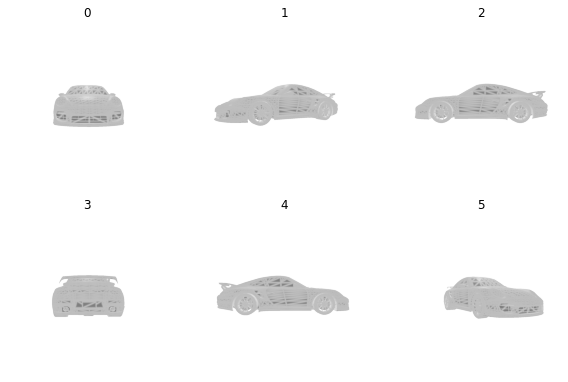

In [18]:
plt.figure(figsize=(10, 10))
for i in list(range(6)) :
  plt.subplot(3,3,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()